In [1]:
import sys
sys.path.append("src")

import os
import torch

from torch import nn
from gradcam import GradCAM1D
from dataset import ECGDataset
from model import ConvNet
from train import train_one_epoch
from utils import *
from torch.utils.data import DataLoader, Subset

# Datasets

In [2]:
path = "archive"

for dirpath, _, filenames in os.walk(path):
    print(*[os.path.join(dirpath, i) for i in filenames], sep='\n')    

archive\mitbih_test.csv
archive\mitbih_train.csv
archive\ptbdb_abnormal.csv
archive\ptbdb_normal.csv


In [3]:
mit_train = ECGDataset('archive/mitbih_train.csv')
mit_test = ECGDataset('archive/mitbih_test.csv')
ptb_normal = ECGDataset('archive/ptbdb_normal.csv')
ptb_abnormal = ECGDataset('archive/ptbdb_abnormal.csv')

In [4]:
ptb = ptb_normal + ptb_abnormal
indices = torch.randperm(len(ptb))
ptb = Subset(ptb, indices)

split_index = int(0.8 * len(ptb))
ptb_train = Subset(ptb, torch.arange(0, split_index, 1))
ptb_test = Subset(ptb, torch.arange(split_index, len(ptb), 1))

# Training MIT-BIH

In [5]:
torch.manual_seed(42)

model = ConvNet()

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
loss_fn = nn.CrossEntropyLoss()
dataloader = DataLoader(mit_train, batch_size=32, shuffle=True)

In [6]:
EPOCHS = 1 

# for epoch in range(EPOCHS):
#     train_one_epoch(
#         model,
#         dataloader,
#         optimizer,
#         loss_fn,
#         epoch,
#         device='cuda'
#     )

# Test MIT-BIH

In [7]:
state_dict = torch.load('weights/model.pt')

model.load_state_dict(state_dict)

test_dataloader = DataLoader(mit_test, batch_size=32, shuffle=True, drop_last=True)
validate(model, test_dataloader)

Average Accuracy: 95.96%
Average F1-score: 0.9511
Average Recall: 0.9596
Average precision: 0.9494


# Training PTB

In [8]:
model_0 = ConvNet()
model_0.load_state_dict(state_dict)

model_0.classifier = nn.Sequential(nn.Flatten(start_dim=1, end_dim=-1),
                              nn.Linear(in_features=128, out_features=32, bias=True),
                              nn.ReLU(),
                              nn.Linear(in_features=32, out_features=2, bias=True)
                                  )

In [9]:
for name, param in model_0.named_parameters():
    if 'classifier' not in name:
        param.requires_grad = False       

In [10]:
optimizer = torch.optim.Adam(model_0.parameters(), lr=1e-5)
loss_fn = nn.CrossEntropyLoss()

dataloader_ptb = DataLoader(ptb_train, batch_size=32, shuffle=True)

model_0.to('cuda');

In [11]:
# for epoch in range(5):
#     train_one_epoch(
#         model_0,
#         dataloader_ptb,
#         optimizer,
#         loss_fn,
#         epoch+1,
#         device="cuda"
#     )

In [12]:
state_dict_transfer = torch.load('weights/model_transfer.pt')
model_0.load_state_dict(state_dict_transfer)

test_dataloader = DataLoader(ptb_test, batch_size=32)
validate(model_0, test_dataloader)

Average Accuracy: 91.17%
Average F1-score: 0.9096
Average Recall: 0.9117
Average precision: 0.9159


# GradCam

In [13]:
for name, param in model_0.named_parameters():
        param.requires_grad = True       

In [17]:
model = model_0
target_layer = model.convnet[4].conv2
gradcam = GradCAM1D(model, target_layer)

i = 0
input_tensor = ptb[i][0].unsqueeze(0)
target_class = ptb[i][1]
cam = gradcam.generate_cam(input_tensor, 0).squeeze().detach().numpy()
cam1 = gradcam.generate_cam(input_tensor, 1).squeeze().detach().numpy()
ecg_signal = input_tensor.squeeze().numpy()

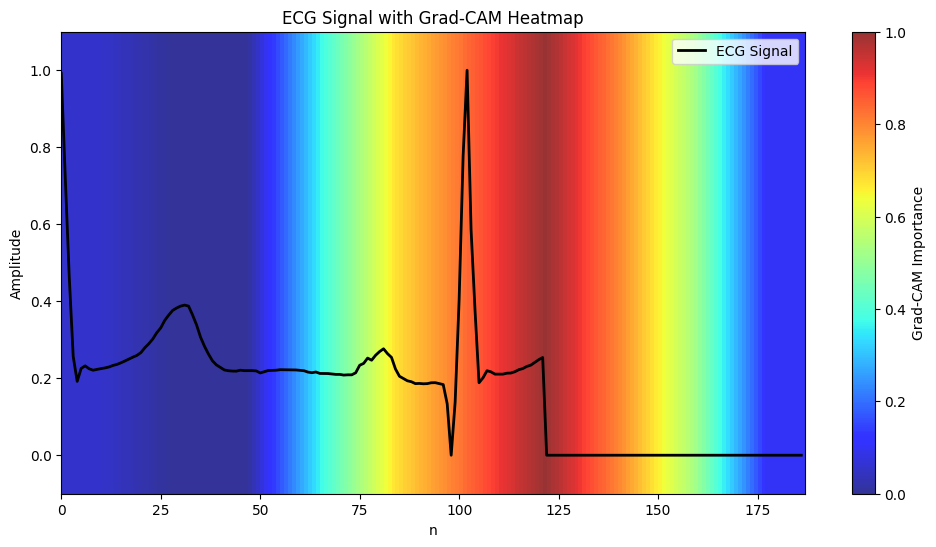

In [18]:
plot_ecg_with_background_cam(cam, ecg_signal)

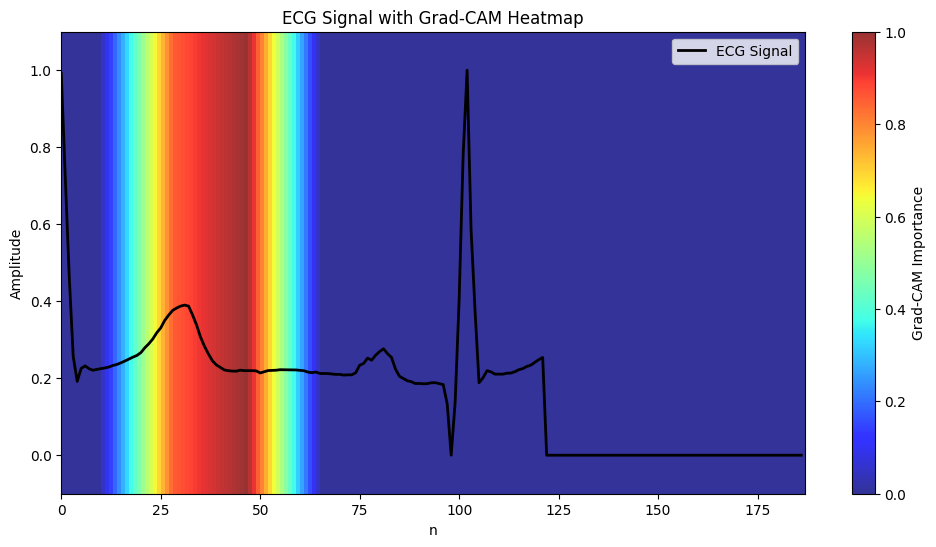

In [19]:
plot_ecg_with_background_cam(cam1, ecg_signal)